In [1]:
import pandas as pd
import numpy as np
# knn and logistic regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
models = [
    "gpt-4o",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

topic = 'high_school_physics'

In [3]:
def load_embeddings(model, source='test'):
    if source == 'test':
        return np.load(f"mmlu/{topic}/{model}-{source}.npy")
    return np.load(f"mmlu/{topic}/{model}-{source}.npy")

In [4]:
def knn(pair):
    train_data = (load_embeddings(pair[0], 'train'), load_embeddings(pair[1], 'train'))
    test_data = (load_embeddings(pair[0], 'test'), load_embeddings(pair[1], 'test'))

    # contrastive, train 0 is label 0, train 1 is label 1
    X_train = np.concatenate([train_data[0], train_data[1]])
    y_train = np.concatenate([np.zeros(train_data[0].shape[0]), np.ones(train_data[1].shape[0])])

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)

    X_test = np.concatenate([test_data[0], test_data[1]])
    y_test = np.concatenate([np.zeros(test_data[0].shape[0]), np.ones(test_data[1].shape[0])])

    return knn.score(X_test, y_test)



In [5]:
def logistic_regression(pair):
    train_data = (load_embeddings(pair[0], 'train'), load_embeddings(pair[1], 'train'))
    test_data = (load_embeddings(pair[0], 'test'), load_embeddings(pair[1], 'test'))

    # contrastive, train 0 is label 0, train 1 is label 1
    X_train = np.concatenate([train_data[0], train_data[1]])
    y_train = np.concatenate([np.zeros(train_data[0].shape[0]), np.ones(train_data[1].shape[0])])

    lr = LogisticRegression()
    lr.fit(X_train, y_train)

    X_test = np.concatenate([test_data[0], test_data[1]])
    y_test = np.concatenate([np.zeros(test_data[0].shape[0]), np.ones(test_data[1].shape[0])])

    return lr.score(X_test, y_test)



In [6]:
all_topic_acc = {}
accuracy_matrix = np.zeros((len(models), len(models)))
log_reg_matrix = np.zeros((len(models), len(models)))
topics = ['high_school_mathematics',
          'high_school_physics',
          'high_school_chemistry',
          'machine_learning',
          'gsm8k']

for topic in topics:
    all_topic_acc[topic] = []
    rslt = []
    for i in range(len(models)):
        for j in range(len(models)):
            model_1 = models[i]
            model_2 = models[j]
            if model_1 == model_2:
                continue
            pair = (model_1, model_2)
            rslt.append({
                'model_1': model_1,
                'model_2': model_2,
                'accuracy': knn(pair),
                'method': 'knn',
                'topic': topic,
            })

            rslt.append({
                'model_1': model_1,
                'model_2': model_2,
                'accuracy': logistic_regression(pair),
                'method': 'logistic_regression',
                'topic': topic,
            })

    df = pd.DataFrame(rslt)
    all_topic_acc[topic] = df

In [7]:
# convert to dataframe
all_topic_df = []
for topic in topics:
    all_topic_df.append(all_topic_acc[topic])

all_topic_df = pd.concat(all_topic_df)

In [8]:
all_topic_df.head()

,model_1,model_2,accuracy,method,topic
0,gpt-4o,Meta-Llama-3-8B-Instruct,0.741667,knn,high_school_mathematics
1,gpt-4o,Meta-Llama-3-8B-Instruct,0.891667,logistic_regression,high_school_mathematics
2,gpt-4o,Meta-Llama-3-70B-Instruct,0.791667,knn,high_school_mathematics
3,gpt-4o,Meta-Llama-3-70B-Instruct,0.933333,logistic_regression,high_school_mathematics
4,gpt-4o,Mistral-7B-Instruct-v0.2,0.666667,knn,high_school_mathematics


In [9]:
# save to csv
all_topic_df.to_csv('mmlu_results_no_paraphrase.csv', index=False)

In [10]:
# average across models

all_topic_df.groupby(['topic', 'method']).mean()


/var/folders/78/7hfmr44j5njd1jd6sv9j23dc0000gn/T/ipykernel_24231/1773522920.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_topic_df.groupby(['topic', 'method']).mean()


accuracy
topic                   method                       
gsm8k                   knn                  0.663333
                        logistic_regression  0.861667
high_school_chemistry   knn                  0.585833
                        logistic_regression  0.798333
high_school_mathematics knn                  0.685000
                        logistic_regression  0.818333
high_school_physics     knn                  0.626667
                        logistic_regression  0.800000
machine_learning        knn                  0.655833
                        logistic_regression  0.821667

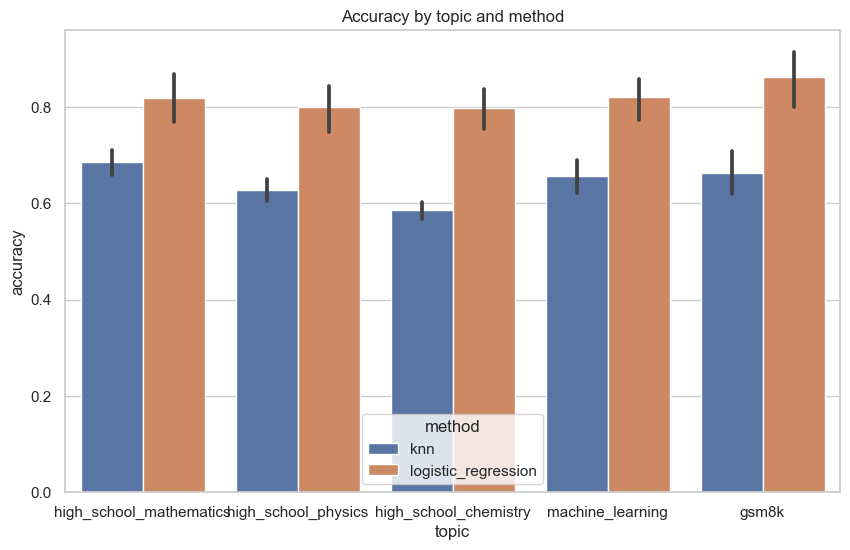

In [11]:
# bar plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='topic', y='accuracy', hue='method', data=all_topic_df)
plt.title('Accuracy by topic and method')
plt.show()